In [48]:
# house prices prediction using TFDF

https://www.kaggle.com/code/gusthema/house-prices-prediction-using-tfdf/notebook

In [7]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import tensorflow_decision_forests as tfdf

In [6]:
print('TensorFlow v: ', tf.__version__)

TensorFlow v:  2.14.0


In [8]:
df = pd.read_csv('./train.csv')
test_df = pd.read_csv('./test.csv')

print(f'df.shape = {df.shape}')
print(f'test_df.shape = {test_df.shape}')

df.shape = (1460, 81)
test_df.shape = (1459, 80)


In [9]:
df.drop(columns = ['Id'], inplace  = True)

In [10]:
# dataset을 랜덤하게 분리하여, train_set과 valid_set을 구분
def split_dataset(dataset, test_ratio = 0.30):
    test_indices = np.random.rand(len(dataset)) < test_ratio
    
    return dataset[~test_indices], dataset[test_indices]

train_df, valid_df = split_dataset(df)
print(f'train_df.shape = {train_df.shape}')
print(f'valid_df.shape = {valid_df.shape}')

train_df.shape = (1028, 80)
valid_df.shape = (432, 80)


In [11]:
label = 'SalePrice'

train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_df,
                                                 label = label,
                                                 task = tfdf.keras.Task.REGRESSION)
valid_ds = tfdf.keras.pd_dataframe_to_tf_dataset(valid_df,
                                                 label = label,
                                                 task = tfdf.keras.Task.REGRESSION)

In [16]:
tfdf.keras.get_all_models()

# RandomForestModel | GradientBoostedTreesModel | CartModel | DistributedGradientBoostedTreesModel

[tensorflow_decision_forests.keras.RandomForestModel,
 tensorflow_decision_forests.keras.GradientBoostedTreesModel,
 tensorflow_decision_forests.keras.CartModel,
 tensorflow_decision_forests.keras.DistributedGradientBoostedTreesModel]

### RandomForest

In [20]:
rf = tfdf.keras.RandomForestModel(task = tfdf.keras.Task.REGRESSION)
rf.compile(metrics = ['mse']) # 평가지표 = mean square error

Use /tmp/tmp95vzk_n3 as temporary training directory


In [22]:
rf.fit(x = train_ds)

Reading training dataset...
Training dataset read in 0:00:06.476676. Found 1028 examples.
Training model...


[INFO 23-11-03 08:13:34.2525 UTC kernel.cc:1233] Loading model from path /tmp/tmp95vzk_n3/model/ with prefix 26580eb95a7e4056


Model trained in 0:00:00.982321
Compiling model...


[INFO 23-11-03 08:13:34.5628 UTC decision_forest.cc:660] Model loaded with 300 root(s), 97810 node(s), and 74 input feature(s).
[INFO 23-11-03 08:13:34.5629 UTC abstract_model.cc:1343] Engine "RandomForestOptPred" built
[INFO 23-11-03 08:13:34.5629 UTC kernel.cc:1061] Use fast generic engine


Model compiled.


In [23]:
tfdf.model_plotter.plot_model_in_colab(rf, tree_idx = 0, max_depth = 3)

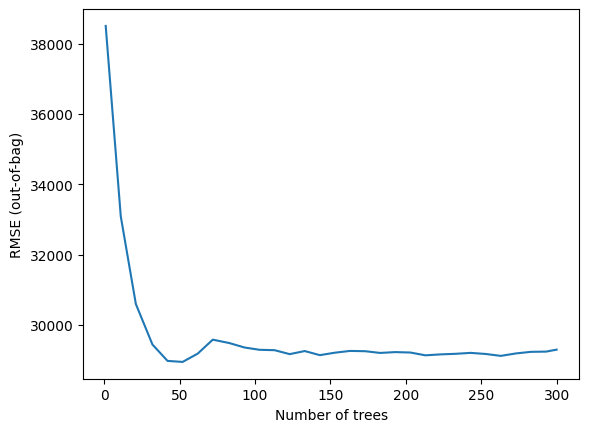

In [25]:
logs = rf.make_inspector().training_logs()

plt.plot([log.num_trees for log in logs],
         [log.evaluation.rmse for log in logs])
plt.xlabel('Number of trees')
plt.ylabel('RMSE (out-of-bag)')
plt.show()

In [26]:
inspector = rf.make_inspector()
inspector.evaluation()

Evaluation(num_examples=1028, accuracy=None, loss=None, rmse=29301.024772699937, ndcg=None, aucs=None, auuc=None, qini=None)

In [30]:
evaluation = rf.evaluate(x = valid_ds,
                         return_dict = True)

for name, value in evaluation.items():
    print(f'{name}: {value:.4f}')

1/1 [==============================] - 1s 676ms/step - loss: 0.0000e+00 - mse: 846030528.0000
loss: 0.0000
mse: 846030528.0000


In [32]:
print(f'Available variable importances:')
for importance in inspector.variable_importances().keys():
    print('\t', importance)
    
# RF 모델에서 생성된 평가 변수들로, 각 변수에 어떤 데이터 특성값들이 영향을 끼쳤는지 아래 코드에서 확인할 수 있다.

Available variable importances:
	 NUM_NODES
	 SUM_SCORE
	 INV_MEAN_MIN_DEPTH
	 NUM_AS_ROOT


In [40]:
inspector.variable_importances()['NUM_AS_ROOT'][:10]

[("OverallQual" (1; #62), 112.0),
 ("ExterQual" (4; #22), 52.0),
 ("GarageCars" (1; #32), 38.0),
 ("Neighborhood" (4; #59), 36.0),
 ("GrLivArea" (1; #38), 20.0),
 ("KitchenQual" (4; #44), 13.0),
 ("GarageArea" (1; #31), 11.0),
 ("YearBuilt" (1; #76), 8.0),
 ("BsmtQual" (4; #14), 5.0),
 ("1stFlrSF" (1; #0), 1.0)]

In [42]:
for (key, val) in inspector.variable_importances().items():
    print(key)
    _ = [print(x) for x in val[:10]]
    print('-' * 50)

NUM_NODES
("Neighborhood" (4; #59), 4185.0)
("GrLivArea" (1; #38), 3716.0)
("TotalBsmtSF" (1; #73), 2641.0)
("GarageArea" (1; #31), 2408.0)
("LotArea" (1; #47), 2204.0)
("BsmtFinSF1" (1; #8), 2017.0)
("1stFlrSF" (1; #0), 1995.0)
("BsmtUnfSF" (1; #15), 1695.0)
("BsmtFinType1" (4; #10), 1561.0)
("Exterior2nd" (4; #24), 1544.0)
--------------------------------------------------
SUM_SCORE
("OverallQual" (1; #62), 451118824945462.2)
("Neighborhood" (4; #59), 232588963185951.75)
("GrLivArea" (1; #38), 203178047521516.56)
("ExterQual" (4; #22), 144744796148392.75)
("GarageCars" (1; #32), 139417738313132.25)
("GarageArea" (1; #31), 97767403572273.47)
("TotalBsmtSF" (1; #73), 86262754453354.81)
("1stFlrSF" (1; #0), 58925997815382.195)
("KitchenQual" (4; #44), 45813872836554.5)
("BsmtQual" (4; #14), 34137303986181.25)
--------------------------------------------------
INV_MEAN_MIN_DEPTH
("OverallQual" (1; #62), 0.22705555646666886)
("Neighborhood" (4; #59), 0.2181471301395116)
("GrLivArea" (1; #

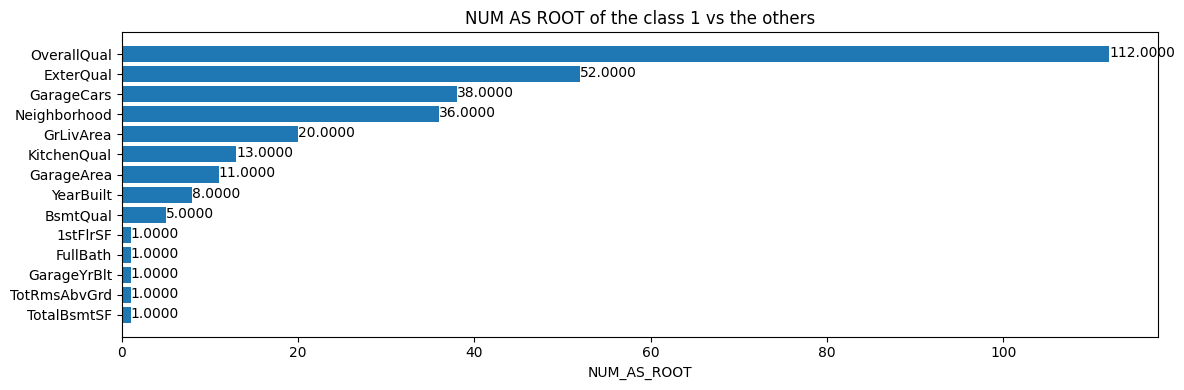

In [44]:
plt.figure(figsize = (12, 4))

variable_importance_metric = 'NUM_AS_ROOT'
variable_importances = inspector.variable_importances()[variable_importance_metric]

feature_names = [vi[0].name for vi in variable_importances]
feature_importances = [vi[1] for vi in variable_importances]
feature_ranks = range(len(feature_names))

bar = plt.barh(feature_ranks,
               feature_importances,
               label = [str(x) for x in feature_ranks])

plt.yticks(feature_ranks, feature_names)
plt.gca().invert_yaxis()

# what is gca?? get the current axis

for importance, patch in zip(feature_importances, bar.patches):
    plt.text(patch.get_x() + patch.get_width(), patch.get_y(), f'{importance:.4f}', va = 'top')
    
plt.xlabel(variable_importance_metric)
plt.title('NUM AS ROOT of the class 1 vs the others')
plt.tight_layout()
plt.show()

### test 데이터에 적용

In [46]:
ids = test_df.pop('Id')

test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test_df,
                                                task =tfdf.keras.Task.REGRESSION)

preds = rf.predict(test_ds)
output = pd.DataFrame({'Id': ids,
                       'SalePrice': preds.squeeze()})

2/2 [==============================] - 1s 22ms/step


In [47]:
output

,Id,SalePrice
0,1461,127136.992188
1,1462,153430.531250
2,1463,178599.031250
3,1464,185029.296875
4,1465,197979.968750
...,...,...
1454,2915,88253.445312
1455,2916,88919.023438
1456,2917,155820.015625
1457,2918,114885.195312
